# Reproducing figures for the paper

In [1]:
import os
notebook_path = os.getcwd()
import numpy as np
import sys
path_root = os.path.abspath("")
sys.path.append(path_root)
from WATRES import *
from WATRES.visualization import *
import pandas as pd
root_data = os.path.join(path_root, 'data/')

import os
directory = os.path.join(path_root, 'figures')
if not os.path.exists(directory):
    os.makedirs(directory)

In [2]:
sites = ['Pully_small_storage'] #['Pully_small_storage','Pully_large_storage','Lugano_small_storage','Lugano_large_storage' ,'Basel_small_storage','Basel_large_storage']
algos = ['WATRES'] # ['WATRES', 'AgeDomain', 'Weibull','EHS']

algo2name = {'WATRES': 'WATRES'}#, 'AgeDomain': 'J-Weighted', 'Weibull':'Weibull','EHS':'EHS'} #  'MESAS':'MESAS',
sitenames = ['Site A-small', 'Site A-large', 'Site B-small', 'Site B-large', 'Site C-small', 'Site C-large']
site2name = {site: sitenames[i] for i, site in enumerate(sites)}
settings = []
for site in sites:
    pathsite = f'{notebook_path}/data/{site}/'
    for algo in algos:
        settings.append({'site':site, 
                        'pathsite': f'{path_root}/data/{site}/',
                        'algo': algo,
                        'path_model': os.path.join(pathsite, 'save', f'save_{site}_seed_0_{algo}.pth.tar'),
                        'path_results': os.path.join(pathsite, 'save', f'results_{site}_seed_0_{algo}.pkl')
                        })
results = gather_results_all_sites(settings)

In [3]:

from scipy.interpolate import interp1d

# getting dates at the hour resolution used to test
hours_test = np.array([fractional_year_to_datetime(el) for el in np.array(results[sites[0]][algos[0]]['timeyear_test'])])

if False:
    ## Getting results from EHS
    res_EHS = {}
    for site in sites:
        res_EHS[site] = {}
        EHS_global = pd.read_csv(os.path.join(root_data, site, 'save', 'EHS_global.txt'), sep=' ')
        res_EHS[site]['TTD_lag'] = EHS_global['TTD_lag'].to_numpy().reshape(-1) * (24*7)
        res_EHS[site]['globalPQ'] = np.cumsum(EHS_global['TTD.TTD'].to_numpy().reshape(-1))
        x_vals = EHS_global['TTD_lag'].to_numpy().reshape(-1)
        y_vals = res_EHS[site]['globalPQ']
        f = interp1d(x_vals, y_vals, kind='linear', fill_value="extrapolate")
        res_EHS[site]['ywfhat'] = (np.array([f(i*4) for i in range(1,11)])).reshape(1,-1)
        for k in range(4):
            EHS_quantile = pd.read_csv(os.path.join(root_data, sites[0], 'save', 'EHS_quantile{0}.txt'.format(k)), sep=' ') 
            res_EHS[site]['quantile{0}_PQ'.format(k)] = np.cumsum(EHS_quantile['QquantileTTD.TTD'].to_numpy().reshape(-1))
            y_vals = res_EHS[site]['quantile{0}_PQ'.format(k)]
            f = interp1d(x_vals, y_vals, kind='linear', fill_value="extrapolate")
            res_EHS[site]['quantile{0}_ywfhat'.format(k)] = (np.array([f(i*4) for i in range(1,11)]))

    for site in sites:
        results[site]['EHS'] = res_EHS[site]
if False:
    ## Getting results from MESAS
    res_MESAS = {}
    for site in sites:
        res_MESAS[site] = {}
        daily_data = pd.read_csv(os.path.join(root_data, site, 'data', f'{site}_daily.txt'))
        ndata = daily_data.shape[0]
        daily_data['datetime'] = pd.to_datetime(daily_data['datetime'], format='%Y-%m-%d')
        daily_data.set_index('datetime', inplace=True)
        target_indexes = np.array([pd.Timestamp(hour.date()) for hour in hours_test])
        idxs_test = np.array([daily_data.index.get_loc(target_index) for target_index in target_indexes])
        daily_data = daily_data.iloc[idxs_test]
        pQttd = np.load(os.path.join(root_data, site, 'save', 'pQ_mesas.npy'))
        pQttd = pQttd[:,:,0].T
        pQ = np.cumsum(pQttd, axis=1)    
        idxs_test = np.array([pQ.shape[0]+(i-ndata) for i in idxs_test])
    
        # Reproduced hydrograph
        df = pd.read_csv(os.path.join(root_data, site, 'data', f'{site}_daily.txt'))
        df = df.iloc[-365*10:]
        Cp = np.nan_to_num(df['Cp'].to_numpy())
        Cq = df['Cq'].to_numpy()[idxs_test]
        Cqhat = np.zeros(len(idxs_test))
        m = pQ.shape[1]
        for i, t in enumerate(idxs_test):
            Cqhat[i] = np.sum( np.flip(Cp[(t-m+1):(t+1)])*pQttd[t,:])
            
        res_MESAS[site]['ERROR_Cout'] = np.linalg.norm(Cqhat-Cq)/len(Cqhat)
        
        pQ = pQ[idxs_test,:]
        res_MESAS[site]['TTD_lag'] = np.arange(pQ.shape[1])*24
        res_MESAS[site]['globalPQ'] = np.mean(pQ, axis=0)
        res_MESAS[site]['ywfhat'] =  (pQ[:,[i*30 for i in range(1,11)]])
        for k in range(4):
            idxs_quantile = np.where(daily_data['Q_quantile_{0}'.format(k)])[0]
            res_MESAS[site]['quantile{0}_PQ'.format(k)] = np.mean(pQ[idxs_quantile,:], axis=0)
            res_MESAS[site]['quantile{0}_ywfhat'.format(k)] = ((res_MESAS[site]['quantile{0}_PQ'.format(k)])[[i*30 for i in range(1,11)]])

In [4]:
# for k in range(4):
#     plt.plot(results[sites[0]]['MESAS']['quantile{0}_PQ'.format(k)][:])
#     plt.plot(results[sites[0]]['Weibull']['quantile{0}_PQhat'.format(k)][:24*365], color='black')

# 1. Young water fraction

In [5]:
def show_ywf(results, algo2name=None, site2name=None):
    size_marker = 100
    algo2name = get_names_algos(results, algo2name)
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    markers = ['*','+', 'x',  'd','.','|']
    colors = ['red', 'orange', 'blue',  'green', 'brown', 'purple']
    mark = {algo:markers[i] for i,algo in enumerate(list(algo2name.keys()))}
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    tickslabel = []
    count_fig = 0
    for site, res_site in results.items():
        count_fig += 1
        count_algo = 0
        for algo, value in res_site.items():
            mean_ywf = np.mean(res_site[algo]['ywfhat'][:, 2])
            if count_fig==1:
                plt.scatter([count_fig], mean_ywf, label=algo2name[algo], marker=mark[algo], c=color[algo], s=size_marker, alpha=0.7)
            else:
                plt.scatter([count_fig], mean_ywf, marker=mark[algo], c=color[algo], s=size_marker, alpha=0.7)
            count_algo += 1
            if count_algo==1:
                mean_ywf_true = np.mean(res_site[algo]['ywf_true'][:,2])
                if count_fig==1:
                    plt.scatter([count_fig], mean_ywf_true, label='Ground truth', marker='_', c='black', s=size_marker)
                else:
                    plt.scatter([count_fig], mean_ywf_true, marker='_', c='black', s=size_marker)

        tickslabel.append(site2name[site])
        

    plt.xticks(list(range(1,count_fig+1)), tickslabel, rotation = 90, fontsize=13)
    plt.legend(
        fontsize=12,
        loc='center',         # Position legend to the left center
        bbox_to_anchor=(0.5, 1.12),   # Move it outside the plot, centered vertically
        ncol=2                     # Set the number of columns
    )

    plt.ylabel('Young water fraction', fontsize=14)
    plt.savefig(os.path.join(directory, 'comparison_ywf.png'), dpi=250, bbox_inches="tight")
    plt.show()

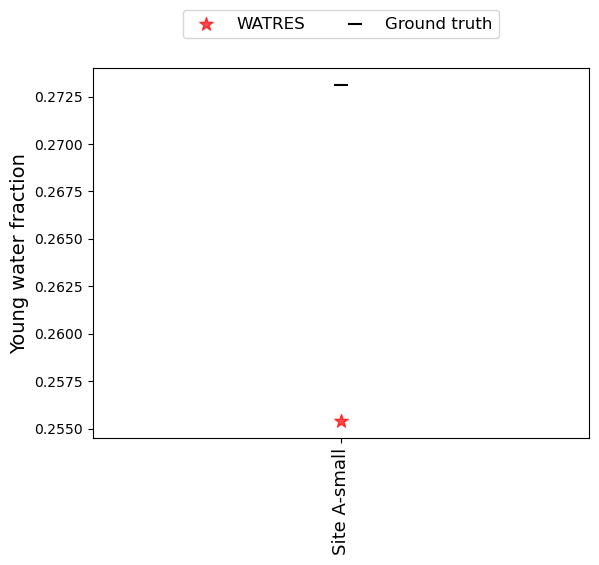

In [6]:
show_ywf(results, algo2name=algo2name, site2name = site2name)

In [7]:
def show_ywf(results, algo2name=None, site2name=None):
    size_marker = 100
    algo2name = get_names_algos(results, algo2name)
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    markers = ['*','+', 'x',  'd','.','|']
    colors = ['red', 'orange', 'blue',  'green','brown', 'purple']
    mark = {algo:markers[i] for i,algo in enumerate(list(algo2name.keys()))}
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    tickslabel = []
    count_fig = 0
    for site, res_site in results.items():
        count_fig += 1
        count_algo = 0
        for algo, value in res_site.items():
            if count_algo==0:
                mean_ywf_true = np.mean(res_site[algo]['ywf_true'][:,2])
            mean_ywf = np.mean(res_site[algo]['ywfhat'][:, 2])
            if count_fig==1:
                plt.scatter([count_fig], np.abs(mean_ywf_true-mean_ywf), label=algo2name[algo], marker=mark[algo], c=color[algo], s=size_marker, alpha=0.7)
            else:
                plt.scatter([count_fig], np.abs(mean_ywf_true-mean_ywf), marker=mark[algo], c=color[algo], s=size_marker, alpha=0.7)
            count_algo += 1
        tickslabel.append(site2name[site])
        

    plt.xticks(list(range(1,count_fig+1)), tickslabel, rotation = 90, fontsize=13)
    plt.legend(
        fontsize=12,
        loc='center',         # Position legend to the left center
        bbox_to_anchor=(0.5, 1.07),   # Move it outside the plot, centered vertically
        ncol=4                     # Set the number of columns
    )

    plt.ylabel('Absolute error on the\naverage young water fraction', fontsize=14)
    plt.savefig(os.path.join(directory,'comparison_ywf.png'), dpi=250, bbox_inches="tight")
    plt.show()

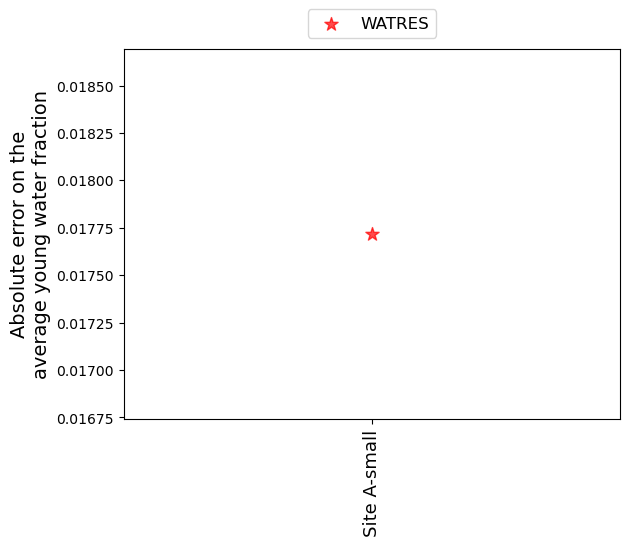

In [8]:
show_ywf(results, algo2name=algo2name, site2name = site2name)

In [9]:
def show_TS_ywf(results, algo2name=None, site2name=None):
    size_marker = 20
    algo2name = get_names_algos(results, algo2name)
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    markers = ['*','+', 'x', '.', 'd','|']
    colors = ['red', 'orange', 'blue', 'brown', 'green', 'purple']
    mark = {algo:markers[i] for i,algo in enumerate(list(algo2name.keys()))}
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    count_fig = 0
    for site, res_site in results.items():
        count_fig += 1
        plt.figure(count_fig)
        count_algo = 0
        for algo, value in res_site.items():
            ywf = res_site[algo]['ywfhat'][:, 2]
            if not(algo in ['EHS','Weibull','AgeDomain']):
                if count_algo==0:
                    algo1 = algo
                    ywf_true = res_site[algo]['ywf_true'][:,2]
                    plt.scatter([],[], label='Ground truth', marker='_', c='black', s=100)
                    plt.scatter(results[site][algo1]['timeyear_test'], ywf_true, marker='_', c='black', s=size_marker)
                plt.scatter([],[], marker=mark[algo], c=color[algo], s=40, alpha=0.7)
                plt.scatter(results[site][algo1]['timeyear_test'], ywf, label=algo2name[algo], marker=mark[algo], c=color[algo], s=size_marker, alpha=0.7)
                count_algo += 1
                    

        plt.legend(
            title=site2name[site],
            fontsize=11,
            loc='center',         # Position legend to the left center
            bbox_to_anchor=(0.5, 0.92),   # Move it outside the plot, centered vertically
            ncol=2                     # Set the number of columns
        )
        #plt.title(site2name[site], fontsize=14)
    
        plt.ylabel('Young water fraction', fontsize=14)
        plt.savefig(os.path.join(directory,'comparison_ywf_{0}.png'.format(site2name[site])), dpi=250, bbox_inches="tight")
        plt.show()

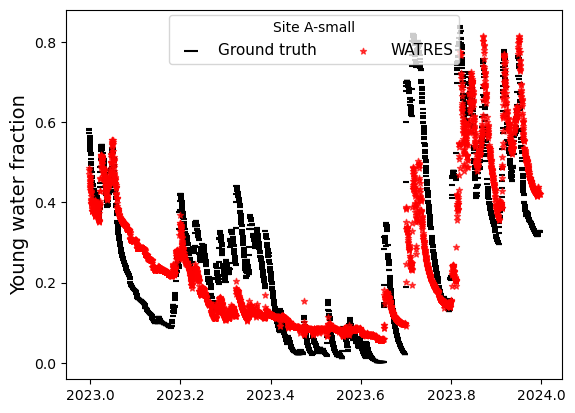

In [10]:
show_TS_ywf(results, algo2name=algo2name, site2name = site2name)

# 2. Global TTD

In [11]:
def show_global_cum_ttd(results, algo2name=None, site2name=None):
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    #colors = {'WATRES': 'red', 'J-weighted': 'orange', 'Weibull': 'blue', 'MESAS':'brown', 'EHS':'green'}
    colors = ['red', 'orange', 'blue', 'brown', 'green', 'purple']
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    x_abs = np.arange(6900)/(24*30)
    count_fig = 0
    for site, res_site in results.items():
        count_algo = 0
        for algo, value in res_site.items():
            plt.figure(count_fig)
            if algo in ['EHS', 'MESAS']:
                x_temp = results[site][algo]['TTD_lag']
                idxs = np.where(x_temp<=6900)[0]
                plt.plot(x_temp[idxs]/(24*30), results[site][algo]['globalPQ'][idxs], color=color[algo], label=algo2name[algo])
            else:
                plt.plot(x_abs, results[site][algo]['global_PQhat'][:6900], color=color[algo], label=algo2name[algo])
            if count_algo==0:
                plt.plot(x_abs, results[site][algo]['global_PQtrue'][:6900], label='Ground truth', linestyle='--', color='black')
            plt.xlabel('Age (in Months)', fontsize=13)
            plt.ylabel('Averaged cumulative TTD', fontsize=14)
            plt.legend()
            plt.title(site2name[site], fontsize=14)
            count_algo += 1
        plt.savefig(os.path.join(directory,'comparison_global_ttd_{0}.png'.format(site2name[site])), dpi=250, bbox_inches="tight")
        plt.show()
        count_fig += 1

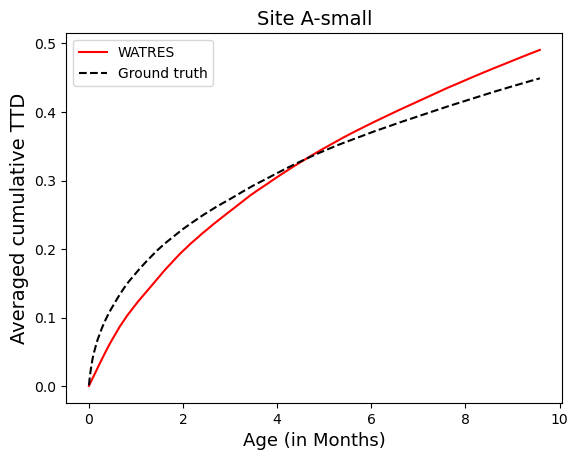

In [12]:
show_global_cum_ttd(results, algo2name=algo2name, site2name=site2name)

# 3. Violin plots

In [13]:
def show_violin_ywf(results, algo2name=None, site2name=None):
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    count_fig = 0
    count_algo = 0
    algo2name = get_names_algos(results, algo2name)
    algo1 = list(algo2name.keys())[0]
    idxalgo = 0
    for algo, name_algo in algo2name.items():
        if algo!='EHS':
            idxalgo += 1
            dataset = []
            lsywf = []
            real_or_esti = []
            tickslabel = []
            plt.figure(num=idxalgo, figsize=(10,5))
        
            for site, res_site in results.items():
                esti_ywf = res_site[algo]['ywfhat'][:,2]
                dataset += [site]*2*len(esti_ywf)
                lsywf += list(esti_ywf)
                true_ywf = res_site[algo1]['ywf_true'][:,2]
                lsywf += list(true_ywf)
                real_or_esti += ['Predicted']*len(esti_ywf)
                real_or_esti += ['Ground truth']*len(esti_ywf)
                tickslabel.append(site2name[site])
        
            df = {'Dataset': dataset, 'Young water fraction': lsywf, 'real_or_esti':real_or_esti}
        
            sns.violinplot(data=df, x="Dataset", y="Young water fraction", hue="real_or_esti", split=True, width=1.3)
            plt.xticks(list(range(0,len(tickslabel))), tickslabel, rotation = 90, fontsize=13)
            plt.legend(fontsize=14,ncol=2)
            plt.title('Model: '+name_algo, fontsize=14)
            plt.savefig(os.path.join(directory,'comparison_violin_{0}.png'.format(name_algo)), dpi=250, bbox_inches="tight")
            plt.show()

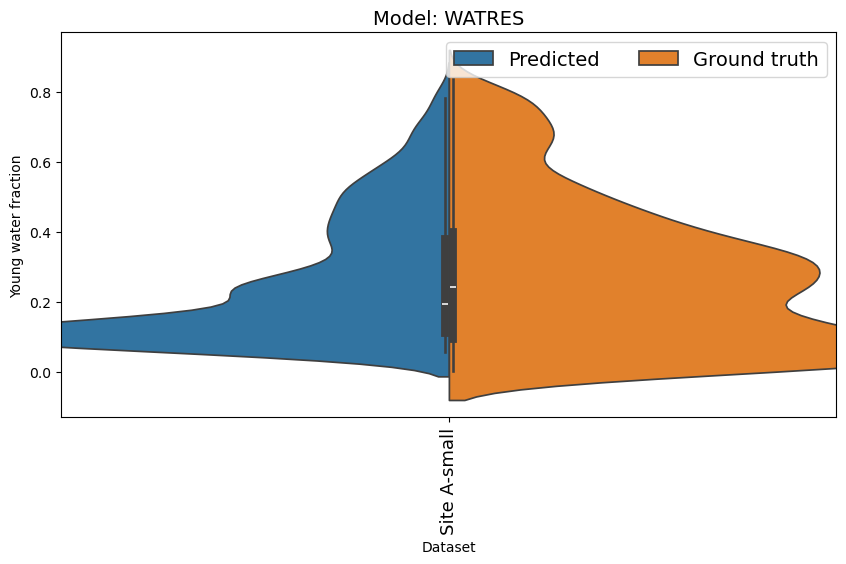

In [14]:
show_violin_ywf(results, algo2name=algo2name, site2name=site2name)

# Errors reproduced output tracer

In [15]:
def show_errors(results, algo2name=None, err='ERROR_Cout', site2name=None):
    size_marker = 100
    algo2name = get_names_algos(results, algo2name)
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    markers = ['*','+', 'x', '.', 'd','|']
    colors = ['red', 'orange', 'blue', 'brown', 'green', 'purple']
    mark = {algo:markers[i] for i,algo in enumerate(list(algo2name.keys()))}
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    tickslabel = []
    count_fig = 0
    for site, res_site in results.items():
        count_fig += 1
        count_algo = 0
        for algo, value in res_site.items():
            if not(algo in ['EHS']):
                if count_fig==1:
                    plt.scatter([count_fig], np.log10(value['ERROR_Cout']), label=algo2name[algo], marker=mark[algo], c=color[algo], s=size_marker, alpha=1)
                else:
                    plt.scatter([count_fig], np.log10(value['ERROR_Cout']), marker=mark[algo], c=color[algo], s=size_marker, alpha=1)
                count_algo += 1

        tickslabel.append(site2name[site])
        
    plt.xticks(list(range(1,count_fig+1)), tickslabel, rotation = 90, fontsize=13)
    plt.legend(
        fontsize=12,
        loc='center',         # Position legend to the left center
        bbox_to_anchor=(0.5, 1.07),   # Move it outside the plot, centered vertically
        ncol=3                     # Set the number of columns
    )

    plt.ylabel('$Log_{10}($ RMSE on the reproduced $C_Q)$', fontsize=14)
    plt.savefig(os.path.join(directory,'comparison_Cq.png'), dpi=250, bbox_inches="tight")
    plt.show()

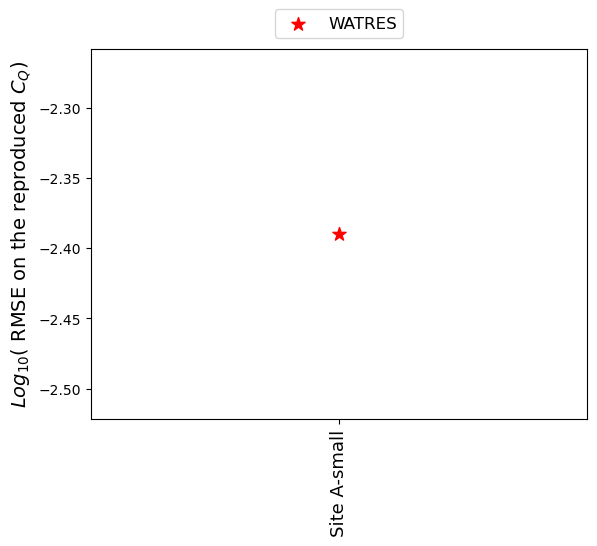

In [16]:
show_errors(results, algo2name=algo2name, site2name=site2name)

# 4. Young water fraction by quantiles

In [17]:
def show_quantile_ywf(results, nb_groups = 10, months_ywf=3, algo2name=None, site2name=None):
    if site2name is None:
        site2name = {el:el for el in list(results.keys())}
    count = 0
    algo2name = get_names_algos(results, algo2name)
    colors = np.flip(get_colors_rainbow(K=nb_groups))
    markers = ['*','+', 'x', '.', 'd','|']
    colors = ['red', 'orange', 'blue', 'brown', 'green', 'purple']
    algo1 = list(algo2name.keys())[0]
    mark = {algo:markers[i] for i,algo in enumerate(list(algo2name.keys()))}
    color = {algo:colors[i] for i,algo in enumerate(list(algo2name.keys()))}
    count_fig = 0
    for site, res_site in results.items():
        plt.figure(count_fig)
        q_true = np.zeros(4)
        for k in range(4):
            q_true[k] = res_site[algo1]['quantile{0}_PQtrue'.format(k)][24*(months_ywf)]
        all_qs = list(q_true)
        for algo, value in res_site.items():
            if algo in ['EHS', 'MESAS']:
                q_esti = np.zeros(4)
                for k in range(4):
                    q_esti[k] = value['quantile{0}_ywfhat'.format(k)][months_ywf-1]
            else:
                q_esti = np.zeros(4)
                for k in range(4):
                    q_esti[k] = value['quantile{0}_PQhat'.format(k)][24*(months_ywf)]
            all_qs += list(q_esti)
            # Plot with different colors for each group and create a legend entry
            for i in range(4):
                if i==0:
                    plt.scatter(
                        q_esti[i],
                        q_true[i],
                        color=color[algo],
                        marker=mark[algo],
                        label=algo2name[algo]
                    )
                else:
                    plt.scatter(
                        q_esti[i],
                        q_true[i],
                        color=color[algo],
                        marker=mark[algo]
                    )

        # Set the same limits for x and y axes
        min_val = np.min(all_qs)
        max_val = np.max(all_qs)
        plt.xlim(min_val, max_val)
        plt.ylim(min_val, max_val)
        plt.plot([min_val,max_val],[min_val,max_val], linestyle='--', c='black')
        plt.xlabel('Predicted', fontsize=13)
        plt.ylabel('Ground truth', fontsize=14)
        plt.legend(title='Model')
        plt.title('{0}'.format(site2name[site]), fontsize=14)
        plt.show()
        count += 1

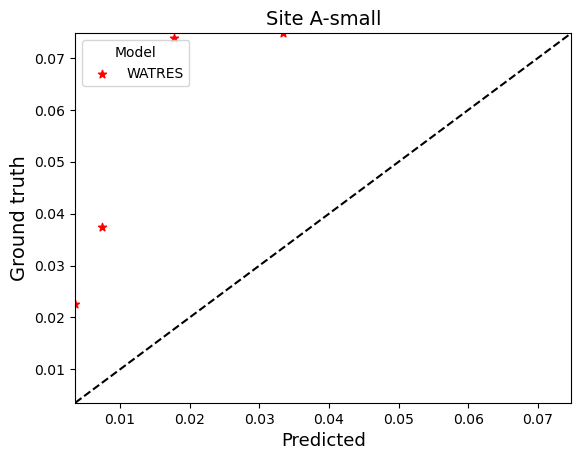

In [18]:
show_quantile_ywf(results, algo2name=algo2name, site2name=site2name)

### Results on the total test set

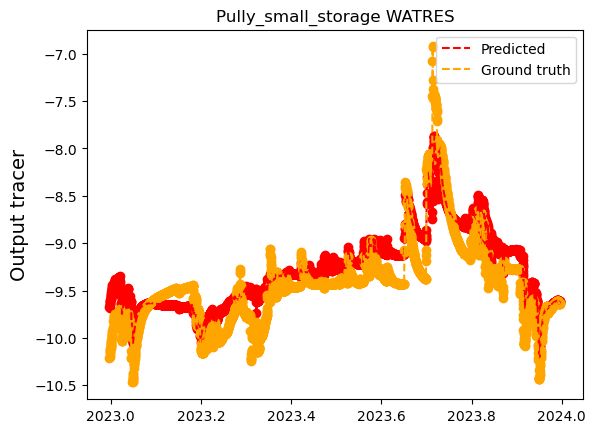

In [19]:
show_Cout(settings, algo2name=algo2name)

### Zooming on a subset of the test set

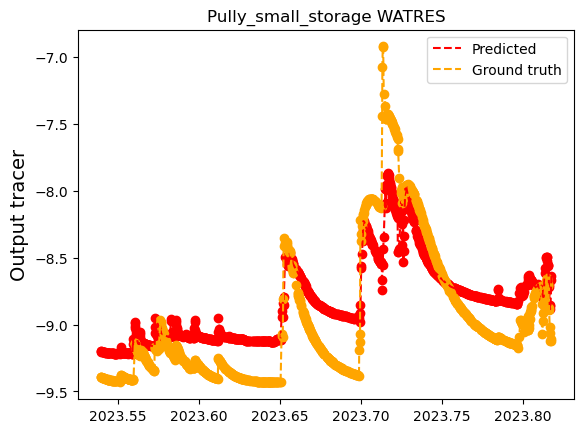

In [20]:
show_Cout(settings, n_start=2000, n_end=3000, algo2name=algo2name)

# 2. Estimated Young Water Fraction

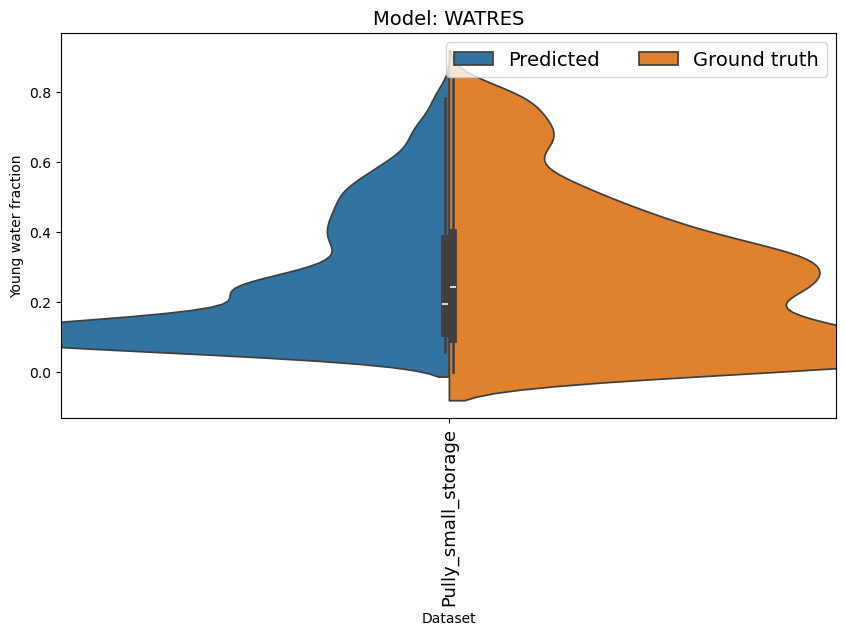

In [21]:
show_violin_ywf(results, algo2name=algo2name)

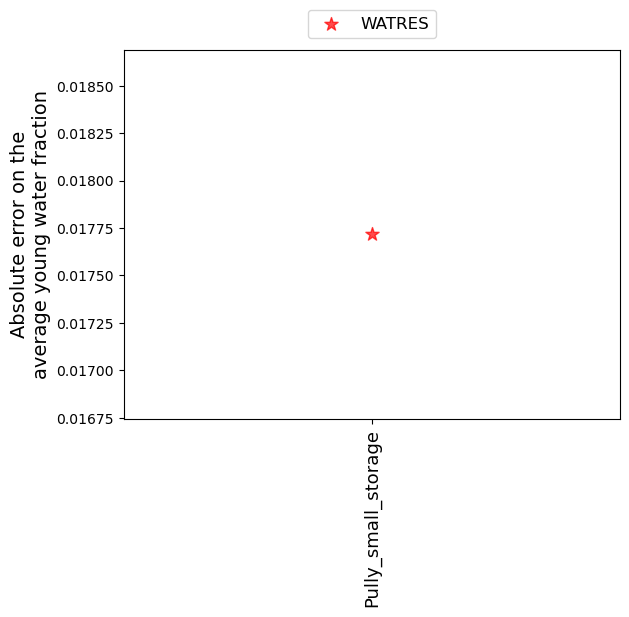

In [22]:
show_ywf(results, algo2name=algo2name)

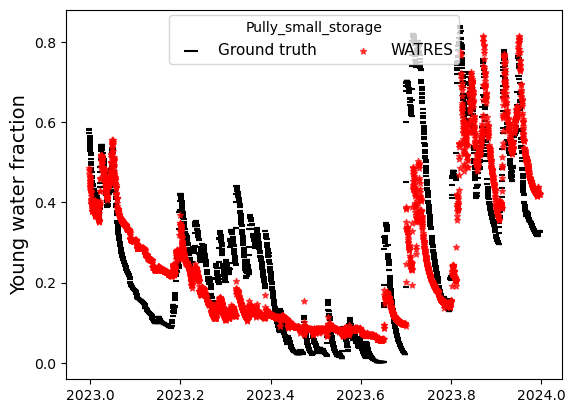

In [23]:
show_TS_ywf(results, algo2name=algo2name)

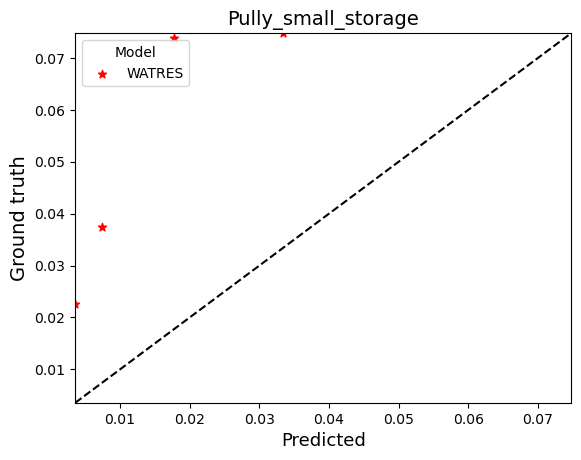

In [24]:
show_quantile_ywf(results)

# 3. Cumulative TTDs

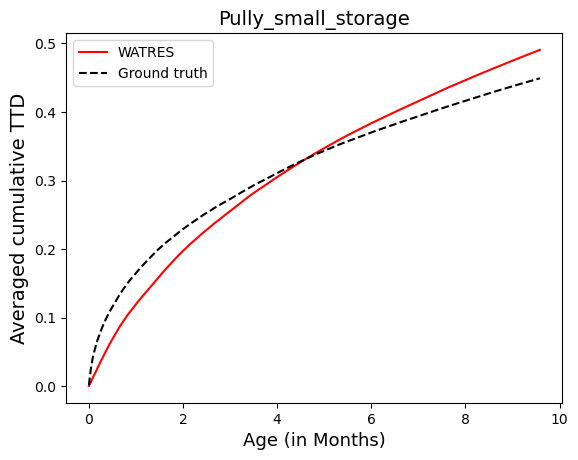

In [25]:
show_global_cum_ttd(results, algo2name=algo2name)

# 4. Survival functions

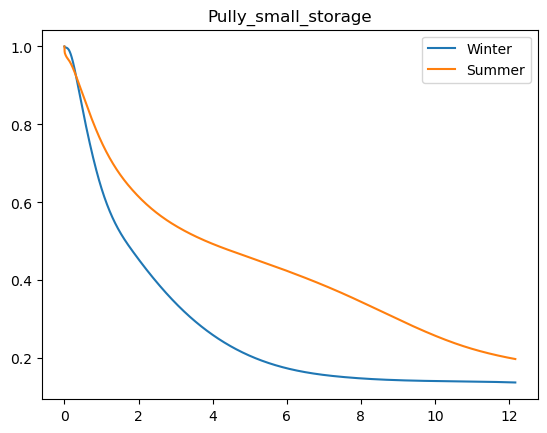

In [34]:
for site in sites:
    plt.plot(np.arange(24*365)/(24*30), results[site][algo]['w_winter'][:24*365], label='Winter')
    plt.plot(np.arange(24*365)/(24*30), results[site][algo]['w_summer'][:24*365], label='Summer')
    plt.legend()
    plt.title(site)
    plt.show()

## The code below allows to visualize time specific TTDs for Pully small storage

In [36]:
# for i in range(20,40):
#     n = results[sites[0]][algo]['PQhat'].shape[1]
#     import random
#     t = random.randint(0, n)
#     plt.plot(results[sites[0]][algo]['PQhat'][:2000,t], label='estimation')
#     plt.plot(results[sites[0]][algo]['PQtrue'][t,:2000], label='ground truth')
#     plt.title('Cumulative TTD at {0}'.format(np.round(results[sites[0]][algo]['timeyear_test'][t], 2)))
#     plt.legend()
#     plt.show()